In [345]:
import json, os, math, time, pprint, io, zipfile, re, shutil
import requests
import geopandas as gpd
import pandas as pd
from shapely.geometry import mapping
from shapely.geometry.polygon import orient
import getpass
import earthaccess
import matplotlib.pyplot as plt
from statistics import mean

import xarray as xr
from datatree import DataTree
import metpy

import rasterio as rio
from rasterio.plot import show

import cartopy.feature as cfeature
import cartopy.crs as ccrs

- https://smap.jpl.nasa.gov/data/
- https://worldview.earthdata.nasa.gov/?v=11.942137748737668,-6.907316273836669,51.83176449832355,14.937003136650842&l=Reference_Features_15m,SMAP_L3_Passive_Enhanced_Day_Soil_Moisture&lg=true&t=2020-09-13-T00%3A00%3A00Z
- https://nsidc.org/data/user-resources/help-center/what-data-subsetting-reformatting-and-reprojection-services-are-available-smap-data
- https://nsidc.org/data/user-resources/help-center/table-key-value-pair-kvp-operands-subsetting-reformatting-and-reprojection-services
- https://nsidc.org/data/user-resources/help-center/programmatic-data-access-guide#anchor-4

# Get Data

## Get South Sudan Shape

In [346]:
countries = gpd.read_file("./data/countries/ne_10m_admin_0_countries.shp")
south_sudan = countries.loc[(countries['SOVEREIGNT'] == 'South Sudan')]
south_sudan = south_sudan.reset_index(drop=True)

## Get SMAP Data

In [347]:
uid = input('Earthdata Login user name: ') # Enter Earthdata Login user name
pswd = getpass.getpass('Earthdata Login password: ') # Enter Earthdata Login password
email = input('Email address associated with Earthdata Login account: ') # Enter Earthdata login email 

In [348]:
short_name = 'SPL3SMP_E'

In [349]:
params = {
    'short_name': short_name
}

cmr_collections_url = 'https://cmr.earthdata.nasa.gov/search/collections.json'
response = requests.get(cmr_collections_url, params=params)
results = json.loads(response.content)

# Find all instances of 'version_id' in metadata and print most recent version number

versions = [el['version_id'] for el in results['feed']['entry']]
latest_version = max(versions)
print('The most recent version of ', short_name, ' is ', latest_version)

The most recent version of  SPL3SMP_E  is  005


In [350]:
start_date = "2020-01-01"
start_time = "00:00:00"
end_date = "2020-12-31"
end_time = "23:59:00"
temporal = start_date + 'T' + start_time + 'Z' + ',' + end_date + 'T' + end_time + 'Z'

In [351]:
aoi = '2'

Simplified polygon coordinates based on shapefile input: 35.92083540900012,4.619331563000088,35.75164676900005,4.85435597700004,35.80415002500007,5.318022767000031,35.46928674300011,5.43075490300015,35.287489054000105,5.374091696000065,35.26196089700005,5.5118869020001,35.0986633710001,5.622474467000046,34.974433228000066,5.863105774000118,34.70354536900004,6.684916077000111,34.52474491400005,6.7528705860000855,34.503660929000034,6.89001983600005,34.28072880000008,6.980091858000023,34.1814066980001,7.1672122190000636,34.03361210100013,7.250256247000024,34.00653365100004,7.4099364220000155,33.71606042500014,7.657156474000075,33.05832279400005,7.797974752000044,32.98979984500011,7.917243958000142,33.1851367590001,8.141080424000066,33.161882365000054,8.361506246000062,33.23515954600009,8.455634867000128,33.62040734900006,8.46069915800011,33.751872193000054,8.368792623000047,33.970773559000065,8.445377096000044,34.111850219000075,8.626554667000079,34.070697863000134,9.454592111000068,33.88

/var/folders/dp/lw4fqnfj31lf3vjjv7f_mgbr0000gn/T/ipykernel_26955/1177713466.py:20: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffer = gdf.buffer(50) #create buffer for plot bounds
/Users/nick/anaconda3/envs/gis/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/var/folders/dp/lw4fqnfj31lf3vjjv7f_mgbr0000gn/T/ipykernel_26955/1177713466.py:25: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


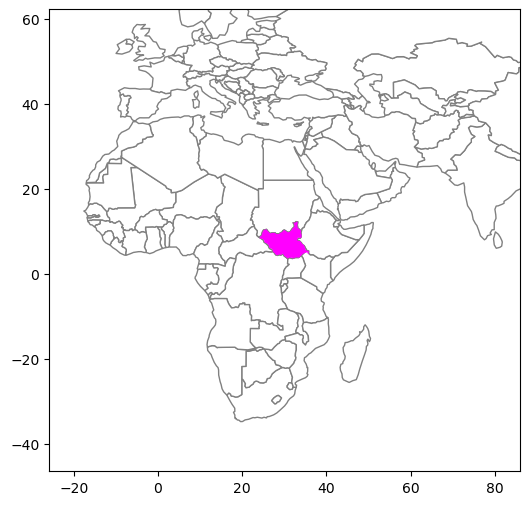

In [372]:
if aoi == '2':
    # Go from geopandas GeoDataFrame object to an input that is readable by CMR
    gdf = south_sudan

    # CMR polygon points need to be provided in counter-clockwise order. The last point should match the first point to close the polygon.
    
    # Simplify polygon for complex shapes in order to pass a reasonable request length to CMR. The larger the tolerance value, the more simplified the polygon.
    # Orient counter-clockwise: CMR polygon points need to be provided in counter-clockwise order. The last point should match the first point to close the polygon.
    
    poly = orient(gdf.simplify(0.05, preserve_topology=False).loc[0],sign=1.0)
    
    geojson = gpd.GeoSeries(poly).to_json() # Convert to geojson
    geojson = geojson.replace(' ', '') #remove spaces for API call

    #Format dictionary to polygon coordinate pairs for CMR polygon filtering
    polygon = ','.join([str(c) for xy in zip(*poly.exterior.coords.xy) for c in xy])

    print('Simplified polygon coordinates based on shapefile input:', polygon)
    
    buffer = gdf.buffer(50) #create buffer for plot bounds
    envelope = buffer.envelope  
    bounds = envelope.bounds
    
    # Load "Natural Earth” countries dataset, bundled with GeoPandas
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

    # Overlay glacier outline
    f, ax = plt.subplots(1, figsize=(12, 6))
    world.plot(ax=ax, facecolor='white', edgecolor='gray')
    gdf.plot(ax=ax, cmap='spring')
    ax.set_ylim([bounds.miny[0], bounds.maxy[0]])
    ax.set_xlim([bounds.minx[0], bounds.maxx[0]]);

In [373]:
granule_search_url = 'https://cmr.earthdata.nasa.gov/search/granules'

# If polygon file input:
search_params = {
'short_name': short_name,
'version': latest_version,
'temporal': temporal,
'page_size': 100,
'page_num': 1,
'polygon': polygon,
}

granules = []
headers={'Accept': 'application/json'}
while True:
    response = requests.get(granule_search_url, params=search_params, headers=headers)
    results = json.loads(response.content)

    if len(results['feed']['entry']) == 0:
        # Out of results, so break out of loop
        break

    # Collect results and increment page_num
    granules.extend(results['feed']['entry'])
    search_params['page_num'] += 1

print('There are', len(granules), 'granules of', short_name, 'version', latest_version, 'over my area and time of interest.')

There are 366 granules of SPL3SMP_E version 005 over my area and time of interest.


In [374]:
granule_sizes = [float(granule['granule_size']) for granule in granules]

print(f'The average size of each granule is {mean(granule_sizes):.2f} MB and the total size of all {len(granules)} granules is {sum(granule_sizes)*.001:.2f} GB')

The average size of each granule is 648.72 MB and the total size of all 366 granules is 237.43 GB


In [375]:
# Query service capability URL 

from xml.etree import ElementTree as ET

capability_url = f'https://n5eil02u.ecs.nsidc.org/egi/capabilities/{short_name}.{latest_version}.xml'

# Create session to store cookie and pass credentials to capabilities url

session = requests.session()
s = session.get(capability_url)
response = session.get(s.url,auth=(uid,pswd))

root = ET.fromstring(response.content)

#collect lists with each service option

subagent = [subset_agent.attrib for subset_agent in root.iter('SubsetAgent')]
if len(subagent) > 0 :

    # variable subsetting
    variables = [SubsetVariable.attrib for SubsetVariable in root.iter('SubsetVariable')]  
    variables_raw = [variables[i]['value'] for i in range(len(variables))]
    variables_join = [''.join(('/',v)) if v.startswith('/') == False else v for v in variables_raw] 
    variable_vals = [v.replace(':', '/') for v in variables_join]

    # reformatting
    formats = [Format.attrib for Format in root.iter('Format')]
    format_vals = [formats[i]['value'] for i in range(len(formats))]
    format_vals.remove('')

    # reprojection options
    projections = [Projection.attrib for Projection in root.iter('Projection')]

In [376]:
#print service information depending on service availability and select service options
    
if len(subagent) < 1 :
    print('No services exist for', short_name, 'version', latest_version)
    agent = 'NO'
    bbox = ''
    time_var = ''
    reformat = ''
    projection = ''
    projection_parameters = ''
    coverage = ''
    Boundingshape = ''
else:
    agent = ''
    subdict = subagent[0]
    if subdict['spatialSubsetting'] == 'true' and aoi == '1':
        Boundingshape = ''
        ss = input('Subsetting by bounding box, based on the area of interest inputted above, is available. Would you like to request this service? (y/n)')
        if ss == 'y': bbox = bounding_box
        else: bbox = '' 
    if subdict['spatialSubsettingShapefile'] == 'true' and aoi == '2':
        bbox = ''
        ps = input('Subsetting by geospatial file (Esri Shapefile, KML, etc.) is available. Would you like to request this service? (y/n)')
        if ps == 'y': Boundingshape = geojson
        else: Boundingshape = '' 
    if subdict['temporalSubsetting'] == 'true':
        ts = input('Subsetting by time, based on the temporal range inputted above, is available. Would you like to request this service? (y/n)')
        if ts == 'y': time_var = start_date + 'T' + start_time + ',' + end_date + 'T' + end_time 
        else: time_var = ''
    else: time_var = ''
    if len(format_vals) > 0 :
        print('These reformatting options are available:', format_vals)
        reformat = input('If you would like to reformat, copy and paste the reformatting option you would like (make sure to omit quotes, e.g. GeoTIFF), otherwise leave blank.')
        if reformat == 'n': reformat = '' # Catch user input of 'n' instead of leaving blank
    else: 
        reformat = ''
        projection = ''
        projection_parameters = ''
    if len(projections) > 0:
        valid_proj = [] # select reprojection options based on reformatting selection
        for i in range(len(projections)):
            if 'excludeFormat' in projections[i]:
                exclformats_str = projections[i]['excludeFormat'] 
                exclformats_list = exclformats_str.split(',')
            if ('excludeFormat' not in projections[i] or reformat not in exclformats_list) and projections[i]['value'] != 'NO_CHANGE': valid_proj.append(projections[i]['value'])
        if len(valid_proj) > 0:
            print('These reprojection options are available with your requested format:', valid_proj)
            projection = input('If you would like to reproject, copy and paste the reprojection option you would like (make sure to omit quotes), otherwise leave blank.')
            # Enter required parameters for UTM North and South
            if projection == 'UTM NORTHERN HEMISPHERE' or projection == 'UTM SOUTHERN HEMISPHERE': 
                NZone = input('Please enter a UTM zone (1 to 60 for Northern Hemisphere; -60 to -1 for Southern Hemisphere):')
                projection_parameters = str('NZone:' + NZone)
            else: projection_parameters = ''
        else: 
            print('No reprojection options are supported with your requested format')
            projection = ''
            projection_parameters = ''
    else:
        print('No reprojection options are supported with your requested format')
        projection = ''
        projection_parameters = ''

These reformatting options are available: ['HDF-EOS5', 'NetCDF4-CF', 'ASCII', 'KML', 'GeoTIFF']
These reprojection options are available with your requested format: ['GEOGRAPHIC', 'UNIVERSAL TRANSVERSE MERCATOR', 'CYLINDRICAL EQUAL AREA', 'NORTH POLAR STEREOGRAPHIC', 'SOUTH POLAR STEREOGRAPHIC']


In [377]:
# Select variable subsetting

if len(subagent) > 0 :
    if len(variable_vals) > 0:
        v = input('Variable subsetting is available. Would you like to subset a selection of variables? (y/n)')
        if v == 'y':
            print('The', short_name, 'variables to select from include:')
            print(*variable_vals, sep = "\n") 
            coverage = input('If you would like to subset by variable, copy and paste the variables you would like separated by comma (be sure to remove spaces and retain all forward slashes: ')
        else: coverage = ''

#no services selected
if reformat == '' and projection == '' and projection_parameters == '' and coverage == '' and time_var == '' and bbox == '' and Boundingshape == '':
    agent = 'NO'

The SPL3SMP_E variables to select from include:
/Soil_Moisture_Retrieval_Data_AM
/Soil_Moisture_Retrieval_Data_AM/albedo
/Soil_Moisture_Retrieval_Data_AM/albedo_dca
/Soil_Moisture_Retrieval_Data_AM/albedo_scah
/Soil_Moisture_Retrieval_Data_AM/albedo_scav
/Soil_Moisture_Retrieval_Data_AM/boresight_incidence
/Soil_Moisture_Retrieval_Data_AM/bulk_density
/Soil_Moisture_Retrieval_Data_AM/clay_fraction
/Soil_Moisture_Retrieval_Data_AM/EASE_column_index
/Soil_Moisture_Retrieval_Data_AM/EASE_row_index
/Soil_Moisture_Retrieval_Data_AM/freeze_thaw_fraction
/Soil_Moisture_Retrieval_Data_AM/grid_surface_status
/Soil_Moisture_Retrieval_Data_AM/latitude
/Soil_Moisture_Retrieval_Data_AM/latitude_centroid
/Soil_Moisture_Retrieval_Data_AM/longitude
/Soil_Moisture_Retrieval_Data_AM/longitude_centroid
/Soil_Moisture_Retrieval_Data_AM/radar_water_body_fraction
/Soil_Moisture_Retrieval_Data_AM/retrieval_qual_flag
/Soil_Moisture_Retrieval_Data_AM/retrieval_qual_flag_dca
/Soil_Moisture_Retrieval_Data_AM/ret

In [378]:
#Set NSIDC data access base URL
base_url = 'https://n5eil02u.ecs.nsidc.org/egi/request'

#Set the request mode to asynchronous if the number of granules is over 100, otherwise synchronous is enabled by default
if len(granules) > 100:
    request_mode = 'async'
    page_size = 2000
else: 
    page_size = 100
    request_mode = 'stream'

#Determine number of orders needed for requests over 2000 granules. 
page_num = math.ceil(len(granules)/page_size)

print('There will be', page_num, 'total order(s) processed for our', short_name, 'request.')

There will be 1 total order(s) processed for our SPL3SMP_E request.


In [379]:
if aoi == '1':
# bounding box search and subset:
    param_dict = {'short_name': short_name, 
                  'version': latest_version, 
                  'temporal': temporal, 
                  'time': time_var, 
                  'bounding_box': bounding_box, 
                  'bbox': bbox, 
                  'format': reformat, 
                  'projection': projection, 
                  'projection_parameters': projection_parameters, 
                  'Coverage': coverage, 
                  'page_size': page_size, 
                  'request_mode': request_mode, 
                  'agent': agent, 
                  'email': email, }
else:
    # If polygon file input:
    param_dict = {'short_name': short_name, 
                  'version': latest_version, 
                  'temporal': temporal, 
                  'time': time_var, 
                  'polygon': polygon,
                  'Boundingshape': Boundingshape, 
                  'format': reformat, 
                  'projection': projection, 
                  'projection_parameters': projection_parameters, 
                  'Coverage': coverage, 
                  'page_size': page_size, 
                  'request_mode': request_mode, 
                  'agent': agent, 
                  'email': email, }

#Remove blank key-value-pairs
param_dict = {k: v for k, v in param_dict.items() if v != ''}

#Convert to string
param_string = '&'.join("{!s}={!r}".format(k,v) for (k,v) in param_dict.items())
param_string = param_string.replace("'","")

#Print API base URL + request parameters
endpoint_list = [] 
for i in range(page_num):
    page_val = i + 1
    API_request = api_request = f'{base_url}?{param_string}&page_num={page_val}'
    endpoint_list.append(API_request)

print(*endpoint_list, sep = "\n") 

https://n5eil02u.ecs.nsidc.org/egi/request?short_name=SPL3SMP_E&version=005&temporal=2020-01-01T00:00:00Z,2020-12-31T23:59:00Z&polygon=35.92083540900012,4.619331563000088,35.75164676900005,4.85435597700004,35.80415002500007,5.318022767000031,35.46928674300011,5.43075490300015,35.287489054000105,5.374091696000065,35.26196089700005,5.5118869020001,35.0986633710001,5.622474467000046,34.974433228000066,5.863105774000118,34.70354536900004,6.684916077000111,34.52474491400005,6.7528705860000855,34.503660929000034,6.89001983600005,34.28072880000008,6.980091858000023,34.1814066980001,7.1672122190000636,34.03361210100013,7.250256247000024,34.00653365100004,7.4099364220000155,33.71606042500014,7.657156474000075,33.05832279400005,7.797974752000044,32.98979984500011,7.917243958000142,33.1851367590001,8.141080424000066,33.161882365000054,8.361506246000062,33.23515954600009,8.455634867000128,33.62040734900006,8.46069915800011,33.751872193000054,8.368792623000047,33.970773559000065,8.445377096000044,3

In [380]:
# Create an output folder if the folder does not already exist.

path = str(os.getcwd() + '/data/smap/netCDF')
if not os.path.exists(path):
    os.mkdir(path)

# Different access methods depending on request mode:

if request_mode=='async':
    # Request data service for each page number, and unzip outputs
    for i in range(page_num):
        page_val = i + 1
        print('Order: ', page_val)

    # For all requests other than spatial file upload, use get function
        param_dict['page_num'] = page_val
        request = session.get(base_url, params=param_dict)

        print('Request HTTP response: ', request.status_code)

    # Raise bad request: Loop will stop for bad response code.
        request.raise_for_status()
        print('Order request URL: ', request.url)
        esir_root = ET.fromstring(request.content)
        print('Order request response XML content: ', request.content)

    #Look up order ID
        orderlist = []   
        for order in esir_root.findall("./order/"):
            orderlist.append(order.text)
        orderID = orderlist[0]
        print('order ID: ', orderID)

    #Create status URL
        statusURL = base_url + '/' + orderID
        print('status URL: ', statusURL)

    #Find order status
        request_response = session.get(statusURL)    
        print('HTTP response from order response URL: ', request_response.status_code)

    # Raise bad request: Loop will stop for bad response code.
        request_response.raise_for_status()
        request_root = ET.fromstring(request_response.content)
        statuslist = []
        for status in request_root.findall("./requestStatus/"):
            statuslist.append(status.text)
        status = statuslist[0]
        print('Data request ', page_val, ' is submitting...')
        print('Initial request status is ', status)

    #Continue loop while request is still processing
        while status == 'pending' or status == 'processing': 
            print('Status is not complete. Trying again.')
            time.sleep(10)
            loop_response = session.get(statusURL)

    # Raise bad request: Loop will stop for bad response code.
            loop_response.raise_for_status()
            loop_root = ET.fromstring(loop_response.content)

    #find status
            statuslist = []
            for status in loop_root.findall("./requestStatus/"):
                statuslist.append(status.text)
            status = statuslist[0]
            print('Retry request status is: ', status)
            if status == 'pending' or status == 'processing':
                continue

    #Order can either complete, complete_with_errors, or fail:
    # Provide complete_with_errors error message:
        if status == 'complete_with_errors' or status == 'failed':
            messagelist = []
            for message in loop_root.findall("./processInfo/"):
                messagelist.append(message.text)
            print('error messages:')
            pprint.pprint(messagelist)

    # Download zipped order if status is complete or complete_with_errors
        if status == 'complete' or status == 'complete_with_errors':
            downloadURL = 'https://n5eil02u.ecs.nsidc.org/esir/' + orderID + '.zip'
            print('Zip download URL: ', downloadURL)
            print('Beginning download of zipped output...')
            zip_response = session.get(downloadURL)
            # Raise bad request: Loop will stop for bad response code.
            zip_response.raise_for_status()
            with zipfile.ZipFile(io.BytesIO(zip_response.content)) as z:
                z.extractall(path)
            print('Data request', page_val, 'is complete.')
        else: print('Request failed.')
            
else:
    for i in range(page_num):
        page_val = i + 1
        print('Order: ', page_val)
        print('Requesting...')
        request = session.get(base_url, params=param_dict)
        print('HTTP response from order response URL: ', request.status_code)
        request.raise_for_status()
        d = request.headers['content-disposition']
        fname = re.findall('filename=(.+)', d)
        dirname = os.path.join(path,fname[0].strip('\"'))
        print('Downloading...')
        open(dirname, 'wb').write(request.content)
        print('Data request', page_val, 'is complete.')
    
    # Unzip outputs
    for z in os.listdir(path): 
        if z.endswith('.zip'): 
            zip_name = path + "/" + z 
            zip_ref = zipfile.ZipFile(zip_name) 
            zip_ref.extractall(path) 
            zip_ref.close() 
            os.remove(zip_name) 


Order:  1
Request HTTP response:  201
Order request URL:  https://n5eil02u.ecs.nsidc.org/egi/request?short_name=SPL3SMP_E&version=005&temporal=2020-01-01T00%3A00%3A00Z%2C2020-12-31T23%3A59%3A00Z&polygon=35.92083540900012%2C4.619331563000088%2C35.75164676900005%2C4.85435597700004%2C35.80415002500007%2C5.318022767000031%2C35.46928674300011%2C5.43075490300015%2C35.287489054000105%2C5.374091696000065%2C35.26196089700005%2C5.5118869020001%2C35.0986633710001%2C5.622474467000046%2C34.974433228000066%2C5.863105774000118%2C34.70354536900004%2C6.684916077000111%2C34.52474491400005%2C6.7528705860000855%2C34.503660929000034%2C6.89001983600005%2C34.28072880000008%2C6.980091858000023%2C34.1814066980001%2C7.1672122190000636%2C34.03361210100013%2C7.250256247000024%2C34.00653365100004%2C7.4099364220000155%2C33.71606042500014%2C7.657156474000075%2C33.05832279400005%2C7.797974752000044%2C32.98979984500011%2C7.917243958000142%2C33.1851367590001%2C8.141080424000066%2C33.161882365000054%2C8.361506246000062%

In [381]:
# Clean up Outputs folder by removing individual granule folders 
for root, dirs, files in os.walk(path, topdown=False):
    for file in files:
        try:
            shutil.move(os.path.join(root, file), path)
        except OSError:
            pass
    for name in dirs:
        os.rmdir(os.path.join(root, name))

# Transform Data

Lets open up one of these files to see what's inside

In [396]:
ds = xr.open_dataset("./data/smap/netCDF/SMAP_L3_SM_P_E_20200101_R18290_004_HEGOUT.nc")
ds

<xarray.Dataset>
Dimensions:  ()
Data variables:
    crs      object ...

Clearly, this doesn't look right. We have no dimensions, but I know that the files aren't corrupted because I can open them in QGIS and `gdalinfo`. I made a post on stack exchange with a more in-depth explination: https://gis.stackexchange.com/questions/468036/how-to-open-netcdf4-cf-files-from-smap-in-xarray

It seems the issue boils down to the fact that each file has 3 subdatasets which need to be opened with rasterio. 

In [397]:
import rasterio
filename = './data/smap/netCDF/SMAP_L3_SM_P_E_20200101_R18290_004_HEGOUT.nc'
with rasterio.open(filename) as src:
    subdatasets = src.subdatasets
subdatasets

['netcdf:./data/smap/netCDF/SMAP_L3_SM_P_E_20200101_R18290_004_HEGOUT.nc:/Soil_Moisture_Retrieval_Data_AM/latitude',
 'netcdf:./data/smap/netCDF/SMAP_L3_SM_P_E_20200101_R18290_004_HEGOUT.nc:/Soil_Moisture_Retrieval_Data_AM/longitude',
 'netcdf:./data/smap/netCDF/SMAP_L3_SM_P_E_20200101_R18290_004_HEGOUT.nc:/Soil_Moisture_Retrieval_Data_AM/soil_moisture']

In [398]:
fname = 'netcdf:./data/smap/netCDF/SMAP_L3_SM_P_E_20200102_R18290_004_HEGOUT.nc:/Soil_Moisture_Retrieval_Data_AM/soil_moisture'
ds = xr.open_dataset(fname, engine="rasterio")
ds

<xarray.Dataset>
Dimensions:        (band: 1, x: 127, y: 94)
Coordinates:
  * band           (band) int64 1
  * x              (x) float64 24.18 24.28 24.37 24.46 ... 35.76 35.85 35.95
  * y              (y) float64 12.17 12.08 11.98 11.89 ... 3.674 3.58 3.487
    /crs           int64 ...
Data variables:
    soil_moisture  (band, y, x) float32 ...

That's better. Thankfully, it looks like the subdataset name is standardized, so we can infer the subdataset fname for each file.

#### Check to see what it looks like on the map

In [399]:
test = ds.soil_moisture

/Users/nick/anaconda3/envs/gis/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


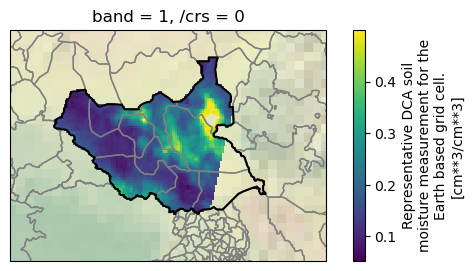

In [400]:
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces',
        scale='10m',
        facecolor='none')
bounds = [21.663731325314046,39.249959603957706,0.8838107955052976,13.743619196613025]

fig=plt.figure(figsize=(7,3))
ax=fig.add_subplot(projection=ccrs.PlateCarree())
test.plot(ax=ax)

south_sudan.boundary.plot(ax=ax,color='black')
ax.add_feature(states_provinces, edgecolor='gray')
ax.set_extent(bounds, crs=ccrs.PlateCarree())
ax.stock_img()

plt.show()

### Extract and combine datasets

We have each day as an individual file, which we need to combine into a three dimensional array over time.

In [401]:
# Get a clean and sorted list of the soil_moisture subdataset from each file
filenames = []
for filename in os.listdir("./data/smap/netCDF/"):
  fname = f'netcdf:./data/smap/netCDF/{filename}:/Soil_Moisture_Retrieval_Data_AM/soil_moisture'
  filenames.append(fname)
filenames.sort()
filenames.pop(0)

'netcdf:./data/smap/netCDF/.DS_Store:/Soil_Moisture_Retrieval_Data_AM/soil_moisture'

In [402]:
filenames[0:5] #Checking

['netcdf:./data/smap/netCDF/SMAP_L3_SM_P_E_20200101_R18290_004_HEGOUT.nc:/Soil_Moisture_Retrieval_Data_AM/soil_moisture',
 'netcdf:./data/smap/netCDF/SMAP_L3_SM_P_E_20200102_R18290_004_HEGOUT.nc:/Soil_Moisture_Retrieval_Data_AM/soil_moisture',
 'netcdf:./data/smap/netCDF/SMAP_L3_SM_P_E_20200103_R18290_004_HEGOUT.nc:/Soil_Moisture_Retrieval_Data_AM/soil_moisture',
 'netcdf:./data/smap/netCDF/SMAP_L3_SM_P_E_20200104_R18290_004_HEGOUT.nc:/Soil_Moisture_Retrieval_Data_AM/soil_moisture',
 'netcdf:./data/smap/netCDF/SMAP_L3_SM_P_E_20200105_R18290_004_HEGOUT.nc:/Soil_Moisture_Retrieval_Data_AM/soil_moisture']

Here, we will create the time dimension and iterate over each filename, opening it and adding the time dimension with the right day. The datasets are still seperate at this point, but they will now have the dimension needed to concatenate them

In [403]:
dataset_list = []
time = pd.date_range("2020-01-01", freq="D", periods=366)
for i, item in enumerate(filenames):
  dataset = xr.open_dataset(item, engine="rasterio")
  dataset.coords["time"] = time[i]
  dataset_list.append(dataset)

Now we concatenate the datasets into one 3d array

In [404]:
combined_dataset = xr.concat(dataset_list, dim="time")
combined_dataset

<xarray.Dataset>
Dimensions:        (band: 1, x: 127, y: 94, time: 366)
Coordinates:
  * band           (band) int64 1
  * x              (x) float64 24.18 24.28 24.37 24.46 ... 35.76 35.85 35.95
  * y              (y) float64 12.17 12.08 11.98 11.89 ... 3.674 3.58 3.487
    /crs           int64 0
  * time           (time) datetime64[ns] 2020-01-01 2020-01-02 ... 2020-12-31
Data variables:
    soil_moisture  (time, band, y, x) float32 nan nan nan nan ... nan nan nan

In [433]:
if "/crs" in combined_dataset.coords:
    combined_dataset.attrs["crs"] = combined_dataset.coords["/crs"].attrs
    combined_dataset = combined_dataset.drop_vars(["/crs"])

In [434]:
combined_dataset

<xarray.Dataset>
Dimensions:        (x: 127, y: 94, time: 366, band: 1)
Coordinates:
  * x              (x) float64 24.18 24.28 24.37 24.46 ... 35.76 35.85 35.95
  * y              (y) float64 12.17 12.08 11.98 11.89 ... 3.674 3.58 3.487
  * time           (time) datetime64[ns] 2020-01-01 2020-01-02 ... 2020-12-31
Dimensions without coordinates: band
Data variables:
    soil_moisture  (time, band, y, x) float32 nan nan nan nan ... nan nan nan
Attributes:
    crs:      {'crs_wkt': 'GEOGCS["unknown",DATUM["WGS84",SPHEROID["Spheroid"...

In [435]:
sm = combined_dataset.soil_moisture

/Users/nick/anaconda3/envs/gis/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


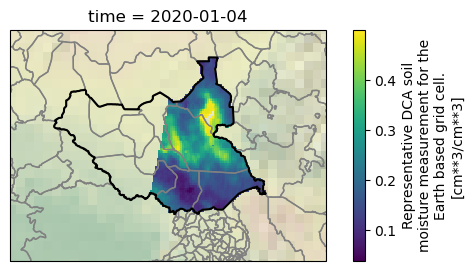

In [436]:
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces',
        scale='10m',
        facecolor='none')
bounds = [21.663731325314046,39.249959603957706,0.8838107955052976,13.743619196613025]

fig=plt.figure(figsize=(7,3))
ax=fig.add_subplot(projection=ccrs.PlateCarree())
sm.isel(time=3).plot(ax=ax)

south_sudan.boundary.plot(ax=ax,color='black')
ax.add_feature(states_provinces, edgecolor='gray')
ax.set_extent(bounds, crs=ccrs.PlateCarree())
ax.stock_img()

plt.show()

### Fill in missing values
Due to the way the SMAP satellites collect data, each day includes "stripes" running primarily north to south that shift laterally each day. This means that on any given day, some or all of south sudan will have null data, as you can see in the plots above.
To run meaningful analysis, we need to fill in these null values. To do that, we will break south sudan into a grid, with each pixel being one square on that grid. We will average each square temporally between days when it has data.
For example, if a square has a value of 10 on 2020-01-01 and no data until 2020-01-04, when it has 20 then we will assume a linear connection between the two datapoints on the days between.
| Day        | soil_moisture_raw | soil_moisture_interpolated |
| ---------- | ----------------- | -------------------------- |
| 2020-01-01 | 10                | 10                         |
| 2020-01-02 | null              | 13.3                       |
| 2020-01-03 | null              | 16.6                       |
| 2020-01-04 | 20                | 20                         |

Thankfully, xarray has a handy function to do just this https://docs.xarray.dev/en/stable/generated/xarray.DataArray.interpolate_na.html#xarray.DataArray.interpolate_na

In [437]:
filled_sm = sm.interpolate_na(dim="time", method="linear")

/Users/nick/anaconda3/envs/gis/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


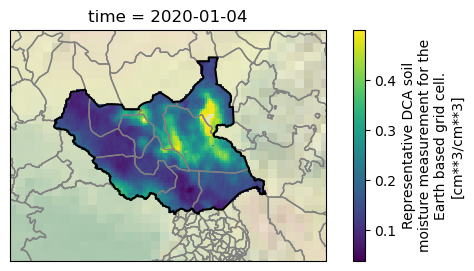

In [438]:
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces',
        scale='10m',
        facecolor='none')
bounds = [21.663731325314046,39.249959603957706,0.8838107955052976,13.743619196613025]

fig=plt.figure(figsize=(7,3))
ax=fig.add_subplot(projection=ccrs.PlateCarree())
filled_sm.isel(time=3).plot(ax=ax)

south_sudan.boundary.plot(ax=ax,color='black')
ax.add_feature(states_provinces, edgecolor='gray')
ax.set_extent(bounds, crs=ccrs.PlateCarree())
ax.stock_img()

plt.show()

In [449]:
filled_sm.to_netcdf("./data/smap/2020_soil_moisture.nc", engine="h5netcdf", invalid_netcdf=True)

/Users/nick/anaconda3/envs/gis/lib/python3.11/site-packages/h5netcdf/core.py:1199: UserWarning: You are writing invalid netcdf features to file `/Users/nick/Code/geospatial-playground/element84/data/smap/2020_soil_moisture.nc`. The file will thus be not conforming to NetCDF-4 standard and might not be readable by other netcdf tools. Consider using a different extension.
  self.flush()


In [411]:
df = filled_sm.to_dataframe()
df = df.reset_index()

In [412]:
df

,time,band,y,x,soil_moisture
0,2020-01-01,0,12.169474,24.183842,NaN
1,2020-01-01,0,12.169474,24.277203,NaN
2,2020-01-01,0,12.169474,24.370564,NaN
3,2020-01-01,0,12.169474,24.463925,NaN
4,2020-01-01,0,12.169474,24.557286,NaN
...,...,...,...,...,...
4369303,2020-12-31,0,3.486902,35.573884,NaN
4369304,2020-12-31,0,3.486902,35.667245,NaN
4369305,2020-12-31,0,3.486902,35.760606,NaN
4369306,2020-12-31,0,3.486902,35.853967,NaN


<Axes: xlabel='time'>

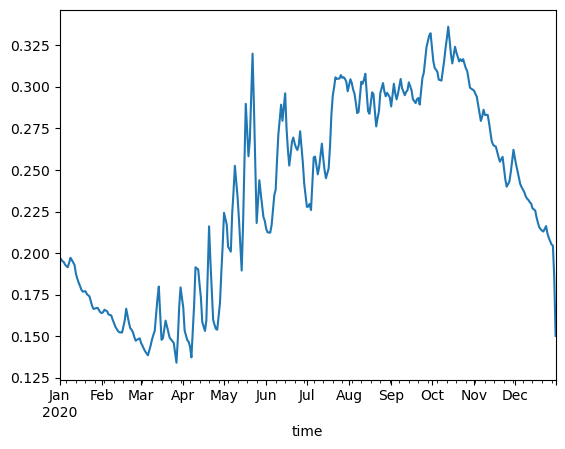

In [413]:
df.groupby('time')['soil_moisture'].mean().plot()